In [167]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import os
import pandas as pd
import json

In [229]:
DIR_NAME = 'metatest_outputs'
files = sorted(os.listdir(DIR_NAME))

In [230]:
#files

In [231]:
experiments = {}
for f in files:
    exp_nr, testset = f.split('_')[0], f.split('_')[1].split('.')[0]
    if experiments.get(exp_nr, False):
        experiments[exp_nr].append((testset, f))
    else:
        experiments[exp_nr] = [(testset, f)]

In [232]:
#experiments

In [233]:
meta_train_filenames = {
    '1': 'boolq_cb_csqa_imdb_mrpc-mnli_qqp_sst_wgrande',
    '3': 'cqa_csqa_hswag_siqa_wgrande-argument_imdb_mnli_mrpc_scitail',
    '4': 'cb_mnli_rte_scitail_sick-argument_imdb_mrpc_qqp',
    '5': 'boolq_mnli_qqp_sst_wgrande-argument_imdb_mrpc_scitail',
    '6': 'argument_boolq_cb_cqa_csqa_hswag_imdb_mnli_mrpc_qqp_rte_scitail_sick_siqa_sst_wgrande-argument_imdb_mrpc_scitail',
    '7': 'argument_boolq_cb_cqa_csqa_hswag_imdb_mnli_mrpc_qqp_rte_scitail_sick_siqa_sst_wgrande-argument_imdb_mnli_mrpc_scitail',
    '8': 'argument_boolq_cb_cqa_csqa_hswag_imdb_mnli_mrpc_qqp_rte_scitail_sick_siqa_sst_wgrande-argument_imdb_mrpc_qqp',
    '9': 'argument_boolq_cb_cqa_csqa_hswag_imdb_mnli_mrpc_qqp_rte_scitail_sick_siqa_sst_wgrande-mnli_qqp_sst_wgrande'
}

In [234]:
exp_setup = {}
for e, f in meta_train_filenames.items():
    exp_setup[e] = {
        "adapters": f.split('-')[0].split('_'),
        "metatrain": f.split('-')[1].split('_')
    }
#exp_setup

In [235]:
with open("results/exp_setup.json", "w") as f:
    f.write(json.dumps(exp_setup))

In [236]:
records = []
for exp_nr, exp_list in experiments.items():
    for dataset, filename in exp_list:
        with open(DIR_NAME + '/' + filename, "r") as f:
            r = json.load(f)
        for k, v in r.items():
            records.append({
                "exp_nr": exp_nr, 
                "exp_id": exp_nr[0],
                "exp_variant": 'a' if len(exp_nr) == 1 else exp_nr[1],
                "metatest": dataset, 
                "K": k, 
                "avg": v[0], 
                "std": v[1]
            })

In [237]:
results = pd.DataFrame.from_records(records)
results

,exp_nr,exp_id,exp_variant,metatest,K,avg,std
0,1,1,a,cb,2,0.298000,0.223456
1,1,1,a,cb,4,0.363636,0.207907
2,1,1,a,cb,8,0.514286,0.071804
3,1,1,a,rte,2,0.497253,0.028045
4,1,1,a,rte,4,0.497212,0.028462
...,...,...,...,...,...,...,...
151,9c,9,c,rte,2,0.514286,0.065444
152,9c,9,c,rte,4,0.542565,0.063312
153,9c,9,c,scitail,2,0.734692,0.072330
154,9c,9,c,scitail,4,0.779128,0.035560


In [238]:
results.to_csv('results/metatest_results.csv', index=False)

In [239]:
results_dict = {}
for exp_nr, exp_list in experiments.items():
    exp_id = exp_nr[0]
    exp_variant = 'a' if len(exp_nr) == 1 else exp_nr[1]
    for dataset, filename in exp_list:
        with open(DIR_NAME + '/' + filename, "r") as f:
            r = json.load(f)
        if results_dict.get((exp_id, dataset), False):
            results_dict[(exp_id, dataset)][exp_variant] = r
        else:
            results_dict[(exp_id, dataset)] = {exp_variant: r}
#results_dict

In [240]:
datasets = results['metatest'].unique()
exp_ids = results['exp_id'].unique()

In [241]:
# Print all results in somewhat formatted table
print("RESULTS BY EXPERIMENT AND DATASET")
print('=' * 113)
print(" "*14, "{:33}{:33}{:33}".format("Hyperparam set A", "Hyperparam set B", "Hyperparam set C"))
print("Exp Dataset   ","{:10}{:10}{:10}   ".format('K=2', 'K=4', 'K=8') * 3)

print('=' * 113)
for exp_id in exp_ids:
    id_printed = False
    for dataset in datasets:
       # print(exp_id, dataset)
        r = results_dict.get((exp_id, dataset), None)
        if r != None:
            print("{:4}{:8} | ".format(exp_id if not id_printed else '', dataset), end='')
            id_printed = True
            for v in ['a', 'b', 'c']:
                values = r.get(v, None)
                if values == None:
                    print(" " * 30, "| ", end='')
                else:
                    for k in ['2', '4', '8']:
                        avg, std = values.get(k, (-1, -1))
                        if avg>0:
                            print("{:1.2f}±{:1.2f} ".format(avg, std), end='')
                        else:
                            print("    -     ", end='')
                    print(" | ", end='')
            print()
    print('-' * 113)

RESULTS BY EXPERIMENT AND DATASET
               Hyperparam set A                 Hyperparam set B                 Hyperparam set C                 
Exp Dataset    K=2       K=4       K=8          K=2       K=4       K=8          K=2       K=4       K=8          
1   cb       | 0.30±0.22 0.36±0.21 0.51±0.07  | 0.35±0.09 0.42±0.08 0.63±0.09  | 0.48±0.10 0.54±0.09     -      | 
    rte      | 0.50±0.03 0.50±0.03 0.51±0.03  | 0.52±0.05 0.53±0.04 0.56±0.06  | 0.52±0.06 0.54±0.08 0.56±0.07  | 
    sick     | 0.33±0.17 0.35±0.18 0.32±0.19  | 0.64±0.10 0.71±0.06 0.73±0.05  | 0.59±0.13 0.69±0.07 0.71±0.06  | 
-----------------------------------------------------------------------------------------------------------------
3   cb       | 0.40±0.16     -         -      | 0.42±0.12 0.45±0.10 0.63±0.06  |                                | 
    rte      | 0.50±0.03 0.50±0.03     -      | 0.51±0.07 0.52±0.06 0.54±0.04  |                                | 
    sick     | 0.35±0.12     -         -      |

In [242]:
# Print all results in somewhat formatted table
print("RESULTS BY DATASET AND EXPERIMENT")
print('=' * 113)
print(" "*14, "{:33}{:33}{:33}".format("Hyperparam set A", "Hyperparam set B", "Hyperparam set C"))
print("Dataset  Exp  ","{:10}{:10}{:10}   ".format('K=2', 'K=4', 'K=8') * 3)

print('=' * 113)
for dataset in datasets:
    id_printed = False
    for exp_id in exp_ids:
        r = results_dict.get((exp_id, dataset), None)
        if r != None:
            print("{:9}{:3} | ".format(dataset if not id_printed else '', exp_id), end='')
            id_printed = True
            for v in ['a', 'b', 'c']:
                values = r.get(v, None)
                if values == None:
                    print(" " * 30, "| ", end='')
                else:
                    for k in ['2', '4', '8']:
                        avg, std = values.get(k, (-1, -1))
                        if avg>0:
                            print("{:1.2f}±{:1.2f} ".format(avg, std), end='')
                        else:
                            print("    -     ", end='')
                    print(" | ", end='')
            print()
    print('-' * 113)

RESULTS BY DATASET AND EXPERIMENT
               Hyperparam set A                 Hyperparam set B                 Hyperparam set C                 
Dataset  Exp   K=2       K=4       K=8          K=2       K=4       K=8          K=2       K=4       K=8          
cb       1   | 0.30±0.22 0.36±0.21 0.51±0.07  | 0.35±0.09 0.42±0.08 0.63±0.09  | 0.48±0.10 0.54±0.09     -      | 
         3   | 0.40±0.16     -         -      | 0.42±0.12 0.45±0.10 0.63±0.06  |                                | 
         6   |                                | 0.36±0.11     -         -      | 0.57±0.12     -         -      | 
         7   |                                | 0.46±0.07     -         -      | 0.47±0.12     -         -      | 
-----------------------------------------------------------------------------------------------------------------
rte      1   | 0.50±0.03 0.50±0.03 0.51±0.03  | 0.52±0.05 0.53±0.04 0.56±0.06  | 0.52±0.06 0.54±0.08 0.56±0.07  | 
         3   | 0.50±0.03 0.50±0.03     -      |

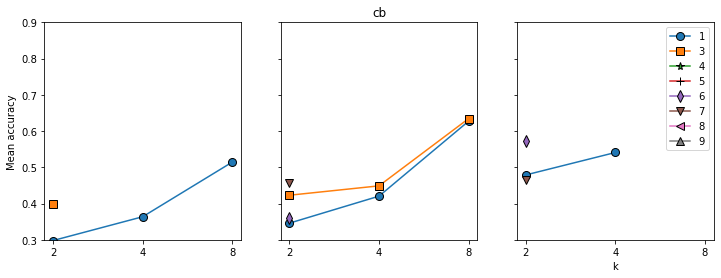

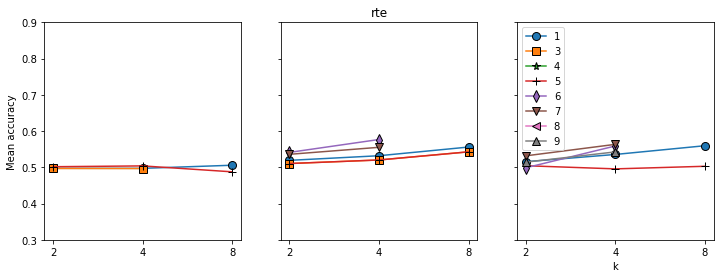

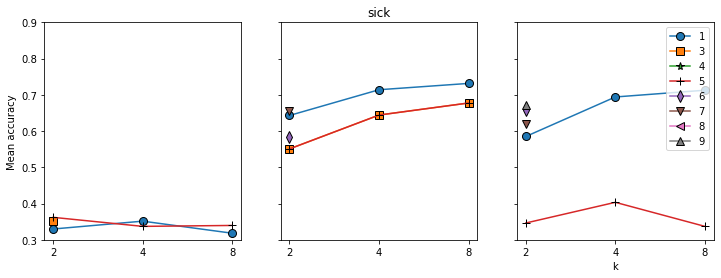

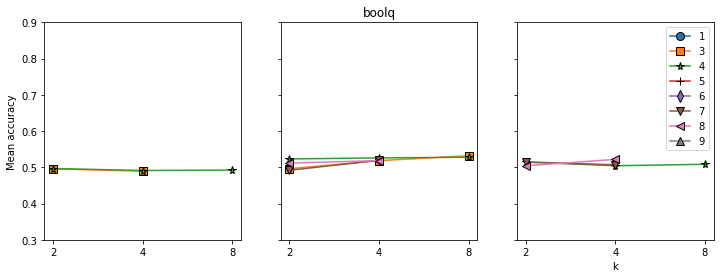

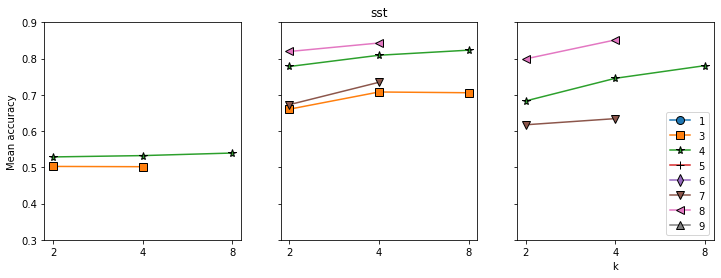

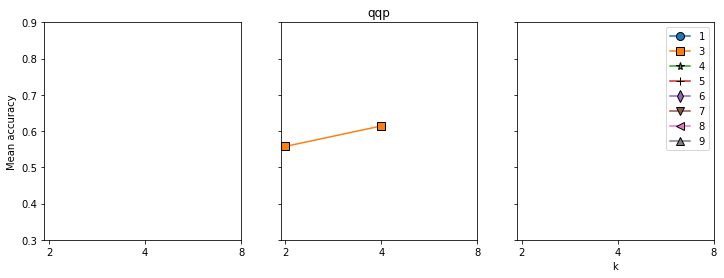

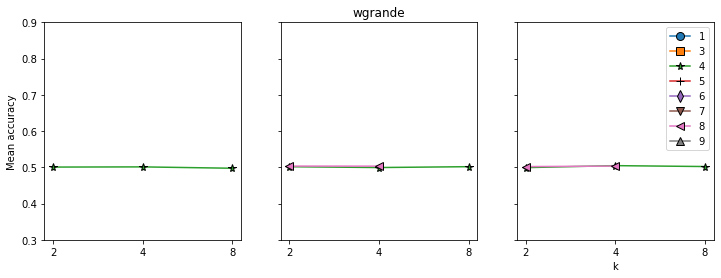

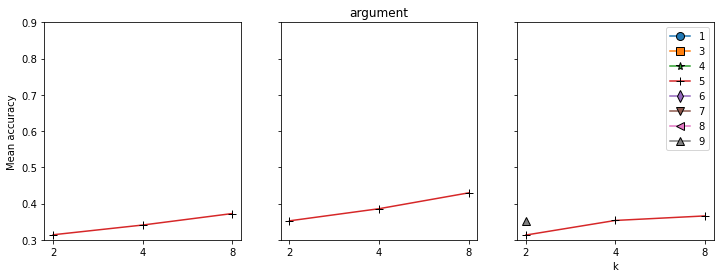

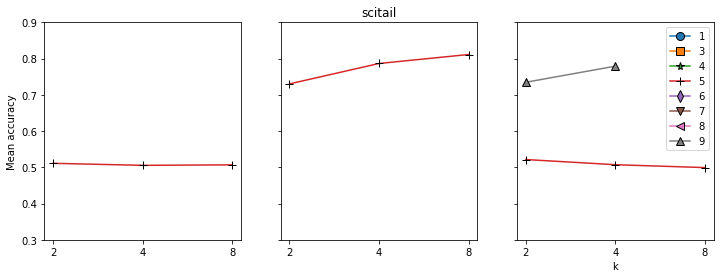

In [243]:
marker=['o', 's', '*', '+', 'd', 'v', '<', '^', '>', '.']
marker_map = dict(zip(exp_ids, marker))

for dataset in datasets:
        
    setup = exp_setup[exp_id]
    exp_results = results.loc[results['metatest'] ==  dataset]    
    fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,4))
       
    for i, v in enumerate(['a', 'b', 'c']):
        
        for exp_id in exp_ids:

            task_df = exp_results.loc[(exp_results['exp_variant'] ==  v) & (exp_results['exp_id'] == exp_id)]
            
            accs = task_df['avg'].values
            stds = task_df['std'].values
            ks = task_df['K'].values
            
            ax[i].plot(ks, accs,  marker=marker_map[exp_id], markeredgecolor='k', markersize=8, label='exp '+exp_id)
            #ax[i].fill_between(ks, [m-s for m,s in zip(accs, stds)], [m+s for m,s in zip(accs, stds)], alpha=0.2, color='red')
        
    plt.xticks(['2', '4', '8'])   
    plt.xlabel('k')
    plt.legend(exp_ids)
    ax[0].set_ylabel('Mean accuracy')
    plt.ylim(0.30, 0.90)
    ax[1].set_title(dataset)
    #ax[2].legend(title='experiment',title_fontsize=10,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    



